In [2]:
## imports

import sys
import os
import numpy as np
import xarray as xr
import cmocean
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import gridspec
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import eofs
from eofs.xarray import Eof
import cftime

# import nc_time_axis

import mtspec

import datetime
import time
import glob, os
import math
import matplotlib.colors as colors

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from defs import Nino34_timeseries, Nino_timeseries, Confidence_intervals, MT_spectrum, FFT_spectrum, trim_axs, find_nearest, MonthConverter

In [47]:
## Figure settings

import matplotlib.pylab as pylab

figwidth1 = 8.3;
figwidth2 = 12;

r = figwidth2/figwidth1;

params1 = {'legend.fontsize':15,
         'axes.labelsize':16.5,
         'axes.titlesize':14.5,
         'xtick.labelsize':14.5,
         'ytick.labelsize':14.5}

params2 = {'legend.fontsize':14.5,
         'axes.labelsize':15.5,
         'axes.titlesize':16.5,
         'xtick.labelsize':14.5,
         'ytick.labelsize':14.5}

cmap_temp = plt.get_cmap('cmo.thermal');
cmap_div  = plt.get_cmap('cmo.balance');
cmap_diff = plt.get_cmap('RdBu_r');

# pylab.rcParams.update(params)

## Load observations

In [5]:
## HadISST data
## https://www.metoffice.gov.uk/hadobs/hadisst/data/download.html
## 1870 - 2020 SST data

file = 'observations/HadISST/HadISST_sst.nc'
ds   = xr.open_dataset(file)

minlat = -5;  maxlat = 5;
minlon = -170; maxlon = -120;
var    = ds.sst; lat = ds.latitude; lon = ds.longitude; 
dimlat = 'latitude'; dimlon = 'longitude'

## calculate nino3.4
Nino34       = var.where(lat>minlat).where(lat<maxlat).where(lon>minlon).where(lon<maxlon).mean(dim=dimlat).mean(dim=dimlon)

# last 100y
Nino34 = Nino34[-1200:]

## take off climatology
nino_hadisst = Nino34.groupby('time.month') - Nino34.groupby('time.month').mean(dim='time')

## last 100y
# nino_hadisst = nino_hadisst[-1200:]

## linear detrending (to remove 'climate change' trends)
t = range(len(nino_hadisst))
p = np.polyfit(t, nino_hadisst, 1)
l = t*p[0] + p[1]
nino_hadisst = nino_hadisst - l

## 30y running mean er af halen?

mtfreq_obs, mtspec_obs = MT_spectrum(nino_hadisst.values, True, True)
mt_ci90_obs, mt_ci95_obs, mt_ci99_obs = Confidence_intervals(nino_hadisst.values, True, True, "linear", 'MT', 10000)

## Load modellist

In [6]:
modellist = ['CCSM4', 'CCSM4-UoT', 'CCSM4-Utr', 'CESM1.2', 'CESM2', 'COSMOS', 'EC-Earth3.3',
             'GISS2.1G', 'HadCM3', 'HadGEM3', 'IPSLCM5A', 'IPSLCM5A2', 'IPSLCM6A', 'MIROC4m', 
             'MRI2.3', 'NorESM-L', 'NorESM1-F']


# Calculate the power spectra & confidence levels

### Nino3.4 index

In [7]:
## Calculate Nino34 index time series 

trend_type = "linear" # linear detrending of Nino34 series
nino_type = 'Nino34' # can also choose other Nino indices, see defs.py

for i in range(0, len(modellist)):
    
    print('model = ' + modellist[i])
    
    ds = Nino_timeseries(model = modellist[i], run='E280', mode = nino_type, trend = trend_type)

    if i==0: 
        nino_e280   = np.zeros((len(ds), len(modellist)))    
        nino_eoi400 = np.zeros((len(ds), len(modellist))) 
        
    nino_e280[:,i]   = ds
    nino_eoi400[:,i] = Nino_timeseries(model = modellist[i], run='EOI400', mode = nino_type, trend = trend_type)



model = CCSM4
model = CCSM4-UoT
model = CCSM4-Utr


/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


model = CESM1.2
model = CESM2
model = COSMOS


/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/numpy

model = EC-Earth3.3


/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/numpy

model = GISS2.1G
model = HadCM3
model = HadGEM3
model = IPSLCM5A
model = IPSLCM5A2
model = IPSLCM6A


/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


model = MIROC4m
model = MRI2.3
model = NorESM-L
model = NorESM1-F


### MT / Fourier spectra

In [8]:
## Calculate power spectrum using FFT or MT spectral methods from Nino3.4 index
# norm: normalize Nino index before computing spectrum,
# scale: scale final power spectrum,
# trend: remove linear trend or not.

norm = True; scale = True; trend = "linear";

for i in range(0, len(modellist)):
    
    print('model = ' + modellist[i])
   
    ## FFT spectrum
#     freq, spec = FFT_spectrum(nino_e280[:,i], norm, scale, trend)
#     if i==0: 
#         mtspec_e280   = np.zeros((len(spec), len(modellist)))    
#         mtspec_eoi400 = np.zeros((len(spec), len(modellist))) 
#         mtfreq_e280   = freq
#         mtfreq_eoi400   = freq
        
#     mtspec_e280[:,i]   = spec
#     _, mtspec_eoi400[:,i] = FFT_spectrum(nino_eoi400[:,i], norm, scale, trend)

    ## MT spectrum
    freq, spec = MT_spectrum(nino_e280[:,i], norm, scale, trend)
    if i==0: 
        mtspec_e280   = np.zeros((len(spec), len(modellist)))    
        mtspec_eoi400 = np.zeros((len(spec), len(modellist))) 
        mtfreq_e280   = freq
        mtfreq_eoi400   = freq
        
    mtspec_e280[:,i]   = spec
    _, mtspec_eoi400[:,i] = MT_spectrum(nino_eoi400[:,i], norm, scale, trend)


model = CCSM4
model = CCSM4-UoT
model = CCSM4-Utr
model = CESM1.2
model = CESM2
model = COSMOS
model = EC-Earth3.3
model = GISS2.1G
model = HadCM3
model = HadGEM3
model = IPSLCM5A
model = IPSLCM5A2
model = IPSLCM6A
model = MIROC4m
model = MRI2.3
model = NorESM-L
model = NorESM1-F


### Confidence intervals

In [9]:
## Calculate confidence intervals using MT spectral methods from Nino3.4 index
# Nsur = number of surrogates
#
# norm: normalize Nino index before computing spectrum,
# scale: scale final power spectrum,
# trend: remove linear trend or not.

norm = True; scale = True; trend = "linear"; Nsur = 10000;

mt_ci90_e280   = np.zeros((len(mtfreq_e280), len(modellist)))
mt_ci95_e280   = np.zeros((len(mtfreq_e280), len(modellist)))
mt_ci99_e280   = np.zeros((len(mtfreq_e280), len(modellist)))
mt_ci90_eoi400 = np.zeros((len(mtfreq_e280), len(modellist)))
mt_ci95_eoi400 = np.zeros((len(mtfreq_e280), len(modellist)))
mt_ci99_eoi400 = np.zeros((len(mtfreq_e280), len(modellist)))

for i in range(0, len(modellist)):
    
    print('model = ' + modellist[i])
   
    mt_ci90_e280[:,i], mt_ci95_e280[:,i], mt_ci99_e280[:,i] = Confidence_intervals(nino_e280[:,i], 
                                                                                   norm, scale, trend, 'MT', Nsur)
    mt_ci90_eoi400[:,i], mt_ci95_eoi400[:,i], mt_ci99_eoi400[:,i] = Confidence_intervals(nino_eoi400[:,i], 
                                                                                         norm, scale, trend, 'MT', Nsur)


model = CCSM4
model = CCSM4-UoT
model = CCSM4-Utr
model = CESM1.2
model = CESM2
model = COSMOS
model = EC-Earth3.3
model = GISS2.1G
model = HadCM3
model = HadGEM3
model = IPSLCM5A
model = IPSLCM5A2
model = IPSLCM6A
model = MIROC4m
model = MRI2.3
model = NorESM-L
model = NorESM1-F


## Optional: compute period of max power

In [29]:
## max period

imin = 9; imax = 67;
period = 1/(12*mtfreq_e280); 

maxperiod_e280   = np.zeros(len(modellist))
maxperiod_eoi400 = np.zeros(len(modellist))

for i in range(len(modellist)):

    maxperiod_e280[i]   = period[imin + np.argmax(mtspec_e280[imin:imax,i])]
    maxperiod_eoi400[i] = period[imin + np.argmax(mtspec_eoi400[imin:imax,i])]

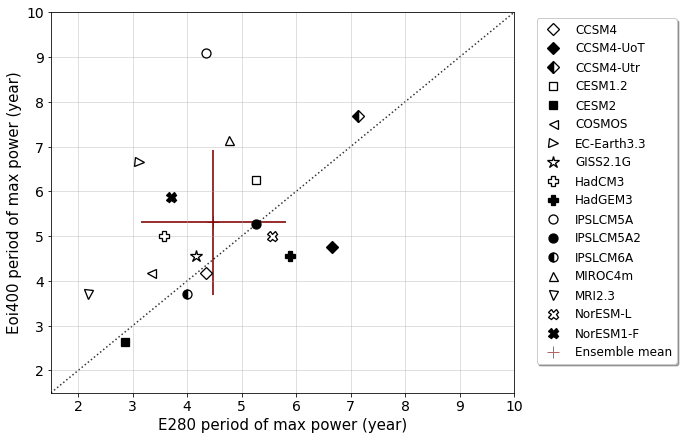

In [37]:
markers = ['D', 'D', 'D', 's', 's', '<', '>', '*', 'P', 'P', 'o', 'o', 'o', '^', 'v', 'X', 'X']
msize   = [8,    8,   8,   8,   8,   9,   9,  13,  10,   10,   9,   9,   9,   9,   9,  10,  10]
colors  = ['w', 'k', 'w', 'w', 'k', 'w', 'w', 'w', 'w', 'k', 'w', 'k', 'w', 'w', 'w', 'w', 'k']
fillstyles = ['full', 'full', 'right', 'full', 'full', 'full', 'full', 'full', 'full', 'full', 'full', 
              'full', 'right', 'full', 'full', 'full', 'full']

fig, ax = plt.subplots(ncols=1,nrows=1,figsize=(figwidth1, 7))

x = maxperiod_e280
y = maxperiod_eoi400
lims = [1.5, 10]

for i in range(len(modellist)):
    ax.plot(x[i], y[i], label = modellist[i], marker = markers[i], markersize = msize[i], color=colors[i], linestyle='None', 
    markeredgecolor ='k', fillstyle = fillstyles[i], markerfacecoloralt = 'k', markeredgewidth=1.3)
    
emcolor = 'maroon';
ax.plot(np.mean(x), np.mean(y), color = emcolor, linestyle = 'None', marker ='+', markersize = 12, label = 'Ensemble mean', zorder=-1, alpha=0.6)    
ax.plot([np.mean(x) - np.std(x), np.mean(x) + np.std(x)], [np.mean(y), np.mean(y)], 
        '-', color = emcolor, zorder=-1, linewidth=2, alpha=0.8)
ax.plot([np.mean(x), np.mean(x)], [np.mean(y) - np.std(y), np.mean(y) + np.std(y)], 
        '-', color = emcolor, zorder=-1, linewidth=2, alpha=0.8)  

# grid
ax.grid(alpha=0.5);
ax.plot(lims, lims,'k:', alpha=0.8, zorder = -1);
ax.plot(lims, [1.0, 1.0], 'k-', alpha=0.6, zorder=-1, linewidth=1)
ax.plot([1.0, 1.0], lims, 'k-', alpha=0.6, zorder=-1, linewidth=1)
ax.set_xlim(lims); ax.set_ylim(lims)

ax.legend(loc='upper center', bbox_to_anchor=(1.20, 1), shadow=True, ncol=1, fontsize=legendfontsize)
ax.set_xlabel('E280 period of max power (year)', fontsize=15); 
ax.set_ylabel('Eoi400 period of max power (year)', fontsize=15);
ax.tick_params(labelsize = 14)

# plt.savefig('figures/periods_max_power.pdf', bbox_inches='tight')


## Plot spectra


# **Appendix Figure 2**

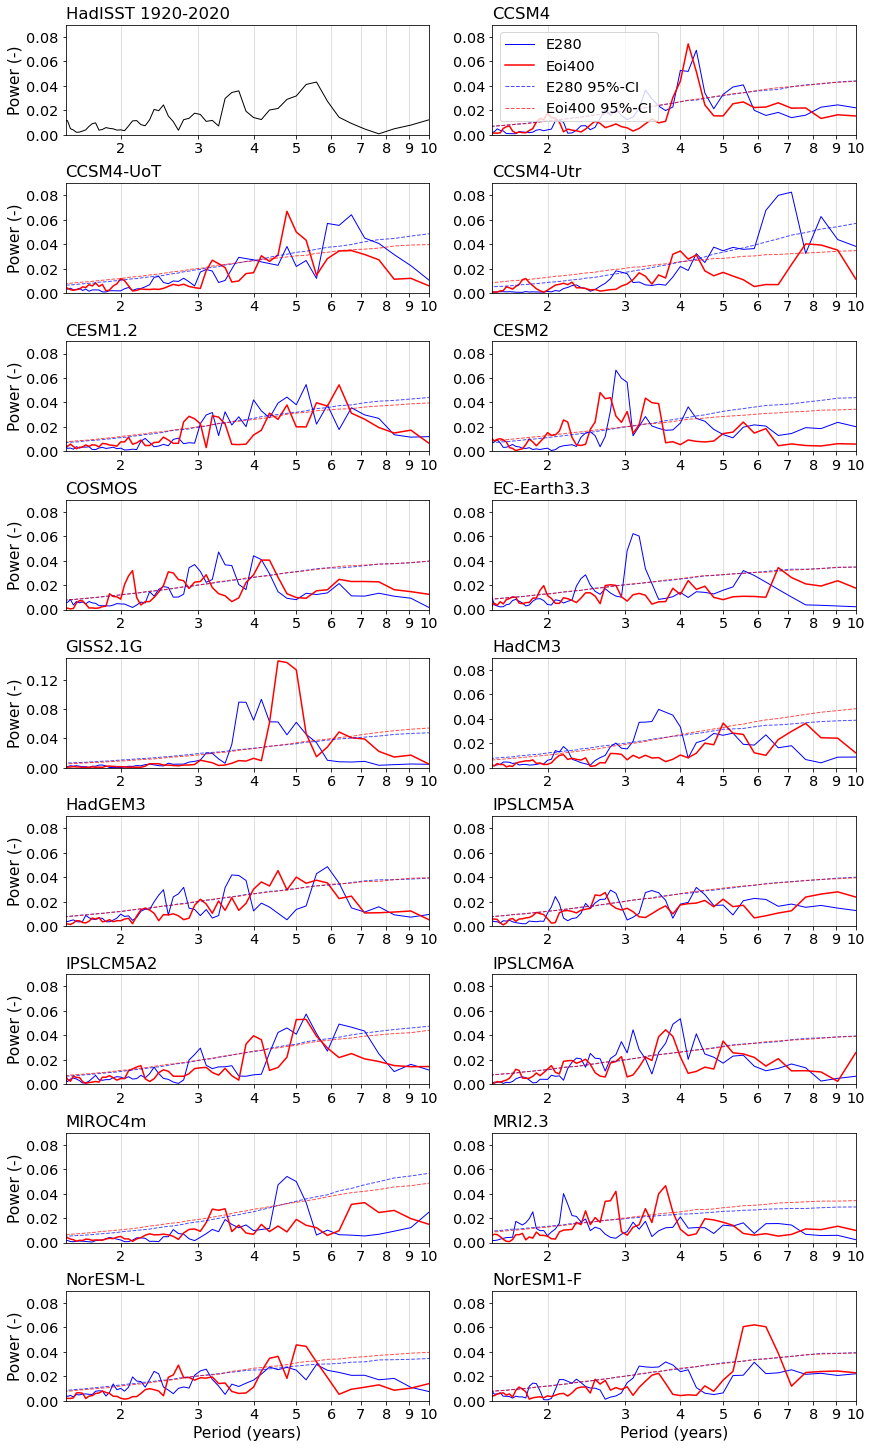

In [12]:
xticks = [2,3,4,5,6,7,8,9,10]

pylab.rcParams.update(params2)
fig1, axs = plt.subplots(nrows=9, ncols=2, figsize=(figwidth2, 20), constrained_layout=True)
axs = trim_axs(axs, len(modellist)+1)

conf = True

for ax1, i in zip(axs, range(0,len(modellist)+1)):

    if i==0:
        ax1.plot(1/(12*mtfreq_obs), mtspec_obs, 'k-', linewidth = 1, alpha = 1., label = 'HadISST')
    else:
        ax1.plot(1/(12*mtfreq_e280), mtspec_e280[:,i-1], '-b', linewidth = 1, label = 'E280')
        ax1.plot(1/(12*mtfreq_eoi400), mtspec_eoi400[:,i-1], '-r', linewidth = 1.5, label = 'Eoi400')
    
    if i>0 and conf == True:
        ax1.plot(1/(12*mtfreq_e280), mt_ci95_e280[:,i-1], 'b--', alpha=0.7, linewidth = 1, label= 'E280 95%-CI')
        ax1.plot(1/(12*mtfreq_eoi400), mt_ci95_eoi400[:,i-1], 'r--', alpha=0.7, linewidth = 1, label='Eoi400 95%-CI')
    
    if i==1:
        ax1.legend(loc='upper left')

    ax1.set_xscale('log')
    
    ax1.set_xlim([1.5,10])
    ax1.set_xticks(xticks)
    ax1.set_xticklabels(xticks)
    if modellist[i-1]=='GISS2.1G':
        ax1.set_ylim([0,0.15])
        ax1.set_yticks([0, .04, .08, .12])
    else:
        ax1.set_ylim([0,0.09])
        ax1.set_yticks([0,.02,.04,.06,.08])
    if i>len(modellist)-2:
        ax1.set_xlabel('Period (years)')
    ax1.xaxis.grid(alpha=0.5)
    ax1.get_xaxis().set_tick_params(which='minor', size=0)
    ax1.get_xaxis().set_tick_params(which='minor', width=0)
    
    if np.mod(i,2)==0:
        ax1.set_ylabel('Power (-)');
    if i==0:
        ax1.set_title('HadISST 1920-2020', loc='left')
    else:
        ax1.set_title(modellist[i-1], loc='left')



plt.savefig('figures/appendixfigure2.pdf', bbox_inches='tight')

# **Figure 3**

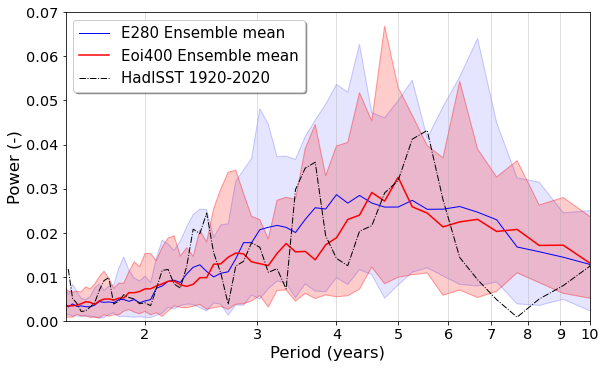

In [51]:
mean_mtspec_e280    = np.mean(mtspec_e280, axis=1)
mean_mtspec_eoi400  = np.mean(mtspec_eoi400, axis=1)
median_mtspec_e280    = np.median(mtspec_e280, axis=1)
median_mtspec_eoi400  = np.median(mtspec_eoi400, axis=1)

x = 1/(12*mtfreq_e280)

## possible to include a range of modelled values around the mean
fill = True;
d=1 #remove largest and smallest value in range

pylab.rcParams.update(params1)
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(figwidth1, 5), constrained_layout=True)

ym = np.mean(mtspec_e280, axis=1)
ys = np.std(mtspec_e280, axis=1)
ax1.plot(x, ym, 'b-', linewidth =1, label = 'E280 Ensemble mean')

y=np.sort(mtspec_e280, axis=1)
if fill == True:
    ax1.fill_between(x, y[:,d], y[:,(-d-1)], color='b', alpha=0.1)
    ax1.plot(x, y[:,d], color='b',  linewidth = 1, alpha=0.1)
    ax1.plot(x, y[:,(-d-1)], color='b',  linewidth = 1, alpha=0.1)

ym = np.mean(mtspec_eoi400, axis=1)
ys = np.std(mtspec_eoi400, axis=1)
ax1.plot(x, ym, 'r-', linewidth = 1.5, label = 'Eoi400 Ensemble mean')

y=np.sort(mtspec_eoi400, axis=1)
if fill == True:
    ax1.fill_between(x, y[:,d], y[:,(-d-1)], color='r', alpha=0.2)
    ax1.plot(x, y[:,d], color='r', linewidth = 1, alpha=0.2)
    ax1.plot(x, y[:,(-d-1)], color='r',  linewidth = 1, alpha=0.2)

ax1.plot(1/(12*mtfreq_obs), mtspec_obs, 'k-.', linewidth = 1.0, alpha = 1, label = 'HadISST 1920-2020')

ax1.legend(loc='upper left', shadow=True)

ax1.set_xscale('log')
    
ax1.set_xlim([1.5, 10])
ticks = [2,3,4,5,6,7,8,9,10]
ax1.set_xticks(ticks)
ax1.set_xticklabels(ticks)
ax1.set_xlabel('Period (years)')
ax1.xaxis.grid(alpha=0.5)
ax1.get_xaxis().set_tick_params(which='minor', size=0)
ax1.get_xaxis().set_tick_params(which='minor', width=0)
ax1.set_ylim([0, 0.07])

ax1.set_ylabel('Power (-)');

# plt.savefig('figures/median_power_spectra.eps', bbox_inches='tight', dpi=200)
# plt.savefig('figures/mean_power_spectra.pdf', bbox_inches='tight')
# plt.savefig('figures/figure3.pdf', bbox_inches='tight')


## Count significant peaks procedure

In [32]:
# count the peaks in the power spectrum that are above the 90, 95 and 99% confidence levels.

m=0; n=0;

peaks_90_e280 = np.array([0.]);   peaks_95_e280 = np.array([0.]);   peaks_99_e280 = np.array([0.]);
peaks_90_eoi400 = np.array([0.]); peaks_95_eoi400 = np.array([0.]); peaks_99_eoi400 = np.array([0.]);

for i in range(len(modellist)):
    for j in range(1,len(mtfreq_e280)):
        period = 1.0 / mtfreq_e280[j] / 12.0;

        if mtspec_e280[j,i] > mt_ci90_e280[j,i]:
            peaks_90_e280 = np.concatenate((peaks_90_e280, np.array([period])),axis=0)
        if mtspec_e280[j,i] > mt_ci95_e280[j,i]:
            peaks_95_e280 = np.concatenate((peaks_95_e280, np.array([period])),axis=0)
        if mtspec_e280[j,i] > mt_ci99_e280[j,i]:
            peaks_99_e280 = np.concatenate((peaks_99_e280, np.array([period])),axis=0)
#             print(f'model = {modellist[i]}, E280: {peaks_99_e280[m+1]}'); m=m+1;
            
        if mtspec_eoi400[j,i] > mt_ci90_eoi400[j,i]:
            peaks_90_eoi400 = np.concatenate((peaks_90_eoi400, np.array([period])),axis=0)
        if mtspec_eoi400[j,i] > mt_ci95_eoi400[j,i]:
            peaks_95_eoi400 = np.concatenate((peaks_95_eoi400, np.array([period])),axis=0)
        if mtspec_eoi400[j,i] > mt_ci99_eoi400[j,i]:
            peaks_99_eoi400 = np.concatenate((peaks_99_eoi400, np.array([period])),axis=0)
#             print(f'model = {modellist[i]}, Eoi400: {peaks_99_eoi400[n+1]}'); n=n+1;
        
peaks_90_e280 = peaks_90_e280[1:];     peaks_95_e280 = peaks_95_e280[1:];     peaks_99_e280 = peaks_99_e280[1:];
peaks_90_eoi400 = peaks_90_eoi400[1:]; peaks_95_eoi400 = peaks_95_eoi400[1:]; peaks_99_eoi400 = peaks_99_eoi400[1:]

#observations:
peaks_90_obs = np.array([0.]);   peaks_95_obs = np.array([0.]);   peaks_99_obs = np.array([0.]);
for j in range(1,len(mtfreq_obs)):
        period = 1.0 / mtfreq_obs[j] / 12.0;

        if mtspec_obs[j] > mt_ci90_obs[j]:
            peaks_90_obs = np.concatenate((peaks_90_obs, np.array([period])),axis=0)
        if mtspec_obs[j] > mt_ci95_obs[j]:
            peaks_95_obs = np.concatenate((peaks_95_obs, np.array([period])),axis=0)
        if mtspec_obs[j] > mt_ci99_obs[j]:
            peaks_99_obs = np.concatenate((peaks_99_obs, np.array([period])),axis=0)

peaks_90_obs = peaks_90_obs[1:];     peaks_95_obs = peaks_95_obs[1:];     peaks_99_obs = peaks_99_obs[1:];
           
print("Peak counting procedure finished")

Peak counting procedure finished


# **Figure 4**

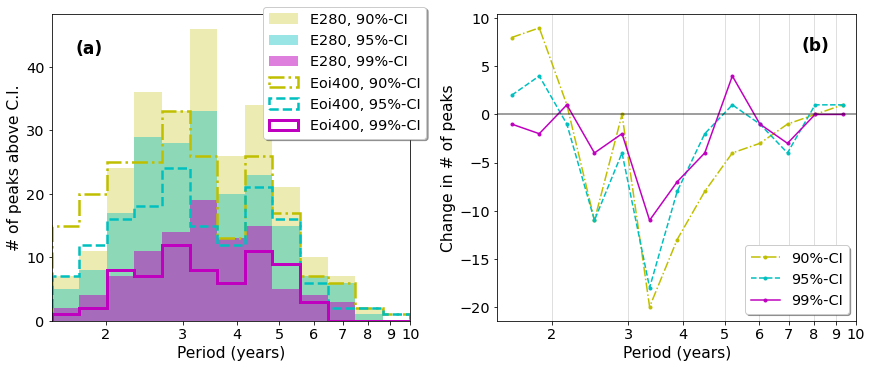

In [41]:
caption = True;

pylab.rcParams.update(params2)
fig, axs = plt.subplots(ncols=2,nrows=1,figsize=(figwidth2,5), constrained_layout=True)

binlist = np.logspace(np.log10(1.5), np.log10(10), 14)
ticklocs = [2,3,4,5,6,7,8,9,10]

ax=axs[0]

ax.hist(peaks_90_e280,   bins=binlist, color='y', histtype = 'stepfilled', alpha=0.3, hatch = '', label = 'E280, 90%-CI')
ax.hist(peaks_95_e280,   bins=binlist, color='c', histtype = 'stepfilled', alpha=0.4, hatch = '', label = 'E280, 95%-CI')
ax.hist(peaks_99_e280,   bins=binlist, color='m', histtype = 'stepfilled', alpha=0.5, hatch = '', label = 'E280, 99%-CI')
ax.hist(peaks_90_eoi400, bins=binlist, color='y', histtype = 'step', alpha=1, linewidth=2.5, linestyle='-.', label = 'Eoi400, 90%-CI')
ax.hist(peaks_95_eoi400, bins=binlist, color='c', histtype = 'step', alpha=1, linewidth=2.5, linestyle='--', label = 'Eoi400, 95%-CI')
ax.hist(peaks_99_eoi400, bins=binlist, color='m', histtype = 'step', alpha=1, linewidth=3, linestyle='-', label = 'Eoi400, 99%-CI')

ax.legend(bbox_to_anchor=(0.57, 0.57),shadow=True)
ax.set_ylabel('# of peaks above C.I.'); 
ax.set_xlabel('Period (years)');
ax.set_xscale("log"); ax.set_xticks(ticklocs); ax.set_xticklabels(ticklocs); ax.set_xlim([1.5,10])
# ax.xaxis.grid(alpha=0.5, zorder=-1)

if caption == True:
    ax.text(1.7, 42, '(a)', fontsize = 17, fontweight = 'bold')

ax=axs[1]

bincenters = np.array([0.])
for i in range(len(binlist)-1):
    center = (binlist[i] + binlist[i+1])/2.
    bincenters = np.concatenate((bincenters, np.array([center])),axis=0)
bincenters = bincenters[1:]

peaknrs = np.zeros((3,2))

hist1, _ = np.histogram(peaks_90_e280,   bins=binlist)
hist2, _ = np.histogram(peaks_90_eoi400, bins=binlist)
diff_90 = hist2 - hist1
peaknrs[0,0] = np.sum(hist1); peaknrs[0,1] = np.sum(hist2)

hist1, _ = np.histogram(peaks_95_e280,   bins=binlist)
hist2, _ = np.histogram(peaks_95_eoi400, bins=binlist)
diff_95 = hist2 - hist1
peaknrs[1,0] = np.sum(hist1); peaknrs[1,1] = np.sum(hist2)

hist1, _ = np.histogram(peaks_99_e280,   bins=binlist)
hist2, _ = np.histogram(peaks_99_eoi400, bins=binlist)
diff_99 = hist2 - hist1
peaknrs[2,0] = np.sum(hist1); peaknrs[2,1] = np.sum(hist2)

ax.plot(bincenters, diff_90, color='y', marker='.', linestyle = '-.')
ax.plot(bincenters, diff_95, color='c', marker='.', linestyle = '--')
ax.plot(bincenters, diff_99, color='m', marker='.', linestyle = '-')

ax.set_ylabel('Change in # of peaks'); 
ax.set_xlabel('Period (years)');
ax.set_xscale("log"); ax.set_xticks(ticklocs); ax.set_xticklabels(ticklocs); ax.set_xlim([1.5,10])
ax.xaxis.grid(alpha=0.5, zorder=-1)
plt.axhline(0, color='black', alpha = 0.5);
ax.legend(['90%-CI', '95%-CI', '99%-CI'], shadow=True, loc='lower right');

if caption == True:
    ax.text(7.5, 6.6, '(b)', fontsize = 17, fontweight = 'bold')

plt.savefig('figures/figure4.pdf', bbox_inches='tight')